## Optical Forces

This tutorial demonstrates Meep's ability to compute classical forces via the [Maxwell stress tensor](https://en.wikipedia.org/wiki/Maxwell_stress_tensor). The geometry consists of two identical, parallel, silicon waveguides with square cross section in vacuum. A schematic of the geometry is shown below. Due to the parallel orientation of the waveguides (propagation axis along $z$ and separation in $x$), the two modes can be chosen to be either symmetric or anti-symmetric with respect to an $x$ mirror-symmetry plane between them. As the two waveguides are brought closer and closer together, their modes couple and give rise to a gradient force that is *transverse* to the waveguide axis (i.e., in the $x$ direction). This is different from [radiation pressure](https://en.wikipedia.org/wiki/Radiation_pressure) which involves momentum exchange between photons and is longitudinal in nature (i.e., along the $z$ direction). An interesting phenomena that occurs for this coupled waveguide system is that the force can be tuned to be either attractive or repulsive depending on the relative phase of the two modes. This tutorial will demonstrate this effect.

![](https://meep.readthedocs.io/en/latest/images/Waveguide_forces.png)

The gradient force $F$ on each waveguide arising from the evanescent coupling of the two waveguide modes can be computed analytically:

$$F=-\frac{1}{\omega}\frac{d\omega}{ds}\Bigg\vert_\vec{k}U$$

where $\omega$ is the mode frequency of the coupled waveguide system, $s$ is the separation distance between the parallel waveguides, $k$ is the conserved wave vector, and $U$ is the total energy of the electromagnetic fields. By convention, negative and positive values correspond to attractive and repulsive forces, respectively. For more details, see [Optics Letters, Vol. 30, pp. 3042-4, 2005](https://www.osapublishing.org/ol/abstract.cfm?uri=ol-30-22-3042). This expression has been shown to be mathematically equivalent to the Maxwell stress tensor in [Optics Express, Vol. 17, pp. 18116-35, 2009](http://www.opticsinfobase.org/oe/abstract.cfm?URI=oe-17-20-18116). We will verify this result in this tutorial. In this particular example, only the fundamental mode with odd mirror-symmetry in $y$ shows the bidirectional force.

It is convenient to [normalize the force](https://meep.readthedocs.io/en/latest/Python_User_Interface/#force-spectra) in order to work with [dimensionless quantities](https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep). Since the total transmitted power in the waveguide per unit length is $P=v_gU/L$ where $v_g$ is the group velocity, $U$ is the total energy of the electromagnetic fields (same as before), and $L$ is the waveguide length, we focus instead on the force per unit length per unit power $(F/L)(ac/P)$ where $a$ is the waveguide width/height and $c$ is the speed of light. This dimensionless quantity can be computed in a single simulation.

The gradient force $F$ can be computed using two different methods: (1) using MPB, compute the frequency $\omega$ and group velocity $v_g$ for a given mode over a range of separation distances $s$ and then use a centered [finite-difference](https://en.wikipedia.org/wiki/Finite_difference) scheme to evaluate $F$ using the formula from above, and (2) using Meep, directly compute both the gradient force $F$ and the transmitted power $P$ over the same range of separation distances $s$. This tutorial verifies that (1) and (2) produce equivalent results.

The main component of the Meep script is the function `parallel_waveguide` which computes the force $F$ and transmitted power $P$ given the waveguide separation distance `s` and relative phase of the waveguide modes `xodd=True/False`. The eigenmode frequency $\omega$ is computed first using `get_eigenmode` in order to specify the frequency of the `add_force` and `add_flux` monitors. (Note that when `match_frequency=False`, `get_eigenmode` ignores the input `frequency` parameter.) An [`EigenModeSource`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#eigenmodesource) with `eig_match_freq=False` is then used to launch the guided mode using a pulse (the `frequency` but not the `fwidth` parameter of `GaussianSource` is ignored). Alternatively, a constant-amplitude point/area source can be used to launch the mode but this is less efficient as demonstrated in [Tutorial/Eigenmode Source/Index-Guided Modes in a Ridge Waveguide](https://meep.readthedocs.io/en/latest/Python_Tutorials/Eigenmode_Source/#index-guided-modes-in-a-ridge-waveguide). The waveguide has width/height of $a=1$ μm and a fixed propagation wavevector of $\pi/a$.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 40  # pixels/μm

Si = mp.Medium(index=3.45)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

sx = 5
sy = 3
cell = mp.Vector3(sx + 2 * dpml, sy + 2 * dpml, 0)

a = 1.0  # waveguide width/height

k_point = mp.Vector3(z=0.5)


def parallel_waveguide(s, xodd):
    geometry = [
        mp.Block(
            center=mp.Vector3(-0.5 * (s + a)),
            size=mp.Vector3(a, a, mp.inf),
            material=Si,
        ),
        mp.Block(
            center=mp.Vector3(0.5 * (s + a)), size=mp.Vector3(a, a, mp.inf), material=Si
        ),
    ]

    symmetries = [mp.Mirror(mp.X, phase=-1 if xodd else 1), mp.Mirror(mp.Y, phase=-1)]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        symmetries=symmetries,
        k_point=k_point,
    )

    sim.init_sim()
    EigenmodeData = sim.get_eigenmode(
        0.22,
        mp.Z,
        mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx, sy)),
        2 if xodd else 1,
        k_point,
        match_frequency=False,
        parity=mp.ODD_Y,
    )

    fcen = EigenmodeData.freq
    print("freq:, {}, {}, {}".format("xodd" if xodd else "xeven", s, fcen))

    sim.reset_meep()

    eig_sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=0.1 * fcen),
            size=mp.Vector3(sx, sy),
            center=mp.Vector3(),
            eig_band=2 if xodd else 1,
            eig_kpoint=k_point,
            eig_match_freq=False,
            eig_parity=mp.ODD_Y,
        )
    ]

    sim.change_sources(eig_sources)

    flux_reg = mp.FluxRegion(
        direction=mp.Z, center=mp.Vector3(), size=mp.Vector3(sx, sy)
    )
    wvg_flux = sim.add_flux(fcen, 0, 1, flux_reg)

    force_reg1 = mp.ForceRegion(
        mp.Vector3(0.49 * s), direction=mp.X, weight=1, size=mp.Vector3(y=sy)
    )
    force_reg2 = mp.ForceRegion(
        mp.Vector3(0.5 * s + 1.01 * a), direction=mp.X, weight=-1, size=mp.Vector3(y=sy)
    )
    wvg_force = sim.add_force(fcen, 0, 1, force_reg1, force_reg2)

    sim.run(until_after_sources=1500)

    flux = mp.get_fluxes(wvg_flux)[0]
    force = mp.get_forces(wvg_force)[0]
    print(
        "data:, {}, {}, {}, {}, {}".format(
            "xodd" if xodd else "xeven", s, flux, force, -force / flux
        )
    )

    sim.reset_meep()
    return flux, force

There are four important items to note: (1) a single flux surface is used to compute the Poynting flux in $z$ which spans the entire non-PML region of the cell. This is because in the limit of small waveguide separation distance, two separate flux surfaces for each waveguide would overlap and result in overcounting. The total power through a single flux surface need, by symmetry, only be halved in order to determine the value for a single waveguide. (2) Instead of defining a closed, four-sided "box" surrounding the waveguides, the Maxwell stress tensor is computed using just two line monitors oriented in $y$ (to obtain the force in the perpendicular $x$ direction) with `weight` values of `+1`/`-1` to correctly sum the total force. The force monitors are placed in the vacuum region adjacent to the waveguide rather than on its surface so that the fields are [second-order accurate](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing/). By symmetry, the force in the $y$ direction is zero and need not be computed. (3) Since the `parity`/`eig_parity` parameter of `get_eigenmode`/`EigenModeSource` can only be specified using the $y$ and/or $z$ directions (but *not* $x$, the waveguide separation axis), the `band`/`eig_band` parameter must be set to `1`/`2` to distinguish modes with even/odd $x$-mirror symmetry.  (4) A 2d `cell_size` in $xy$ combined with a `k_point` containing a non-zero $z$ component results in a [2d simulation (which is the default)](https://meep.readthedocs.io/en/latest/2d_Cell_Special_kz/).

In this example, the fields of the guided mode never decay away to zero. [Choosing a runtime](https://meep.readthedocs.io/en/latest/FAQ/#checking-convergence) is therefore somewhat arbitrary but requires some care. A sufficiently long runtime is necessary to obtain the [steady-state response](https://meep.readthedocs.io/en/latest/FAQ/#how-do-i-compute-the-steady-state-fields). However, an excessively long runtime will lead to large values for the Fourier-transformed fields used to compute both the flux and the Maxwell stress tensor. Large floating-point numbers may contain [roundoff errors](https://en.wikipedia.org/wiki/Round-off_error) and produce inaccurate results.

The simulation is run over the range of separation distances $s$ from 0.1 to 1.0 μm in increments of 0.1 μm. The results are compared with those from MPB. This is shown in the top figure. The two methods show good agreement.

In [2]:
s = np.arange(0.1, 1.1, 0.1)
fluxes_odd = np.zeros(s.size)
forces_odd = np.zeros(s.size)
fluxes_even = np.zeros(s.size)
forces_even = np.zeros(s.size)

for k in range(len(s)):
    fluxes_odd[k], forces_odd[k] = parallel_waveguide(s[k], True)
    fluxes_even[k], forces_even[k] = parallel_waveguide(s[k], False)

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00295496 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
time for set_epsilon = 0.0137441 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 239.38333333333333/366.6666717529297 = 65.3% done in 4.0s, 2.1s to go
on time step 14404 (time=240.067), 0.000277733 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2337849185921515, -1.9695192598601073e-09, 59350757.150949866, 0.5581279688138194, -0.5553187433557634-0.055927836092732594i, 2.543717760177644e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.1, 0.2337849185921515
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00183916 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielect

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 211.81666666666666/666.6666717529297 = 31.8% done in 4.0s, 8.6s to go
on time step 12744 (time=212.4), 0.000313893 s/step
Meep progress: 438.3333333333333/666.6666717529297 = 65.7% done in 8.0s, 4.2s to go
on time step 26339 (time=438.983), 0.000294248 s/step
Meep progress: 660.8666666666667/666.6666717529297 = 99.1% done in 12.0s, 0.1s to go
on time step 39695 (time=661.583), 0.000299507 s/step
run 1 finished at t = 666.6666666666666 (40000 timesteps)
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00133109 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
  

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 246.28333333333333/366.6666717529297 = 67.2% done in 4.0s, 2.0s to go
on time step 14810 (time=246.833), 0.000270096 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.21436005656524434, 2.1977416545924374e-08, -4876825.629557369, 1.0437686932994705, -0.6908642657795828-0.7824063211534797i, 3.332567959460228e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.1, 0.21436005656524434
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00119805 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectr

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 83.76666666666667/666.6666717529297 = 12.6% done in 4.0s, 27.8s to go
on time step 5044 (time=84.0667), 0.000793118 s/step
Meep progress: 168.71666666666667/666.6666717529297 = 25.3% done in 8.0s, 23.6s to go
on time step 10144 (time=169.067), 0.000784439 s/step
Meep progress: 255.01666666666665/666.6666717529297 = 38.3% done in 12.0s, 19.4s to go
on time step 15324 (time=255.4), 0.000772402 s/step
Meep progress: 340.3666666666667/666.6666717529297 = 51.1% done in 16.0s, 15.3s to go
on time step 20446 (time=340.767), 0.000780987 s/step
Meep progress: 424.3833333333333/666.6666717529297 = 63.7% done in 20.0s, 11.4s to go
on time step 25484 (time=424.733), 0.00079398 s/step
Meep progress: 509.8/666.6666717529297 = 76.5% done in 24.0s, 7.4s to go
on time step 30615 (time=510.25), 0.00077967 s/step
Meep progress: 594.2/666.6666717529297 = 89.1% done in 28.0s, 3.4s to go
on time step 35680 (time=594.667), 0.000789747 s/step
run 1 finished at t = 666.6666666666666 (40000 times

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.31666666666666/366.6666717529297 = 26.5% done in 4.0s, 11.1s to go
on time step 5854 (time=97.5667), 0.000683346 s/step
Meep progress: 195.31666666666666/366.6666717529297 = 53.3% done in 8.0s, 7.0s to go
on time step 11733 (time=195.55), 0.000680444 s/step
Meep progress: 290.3666666666667/366.6666717529297 = 79.2% done in 12.0s, 3.2s to go
on time step 17439 (time=290.65), 0.000701091 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2321007699342635, -6.589441383742643e-10, 176115664.75642273, 0.7050710049152503, -0.3914039769859229-0.5864537908239694i, 2.563795272483861e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.2, 0.2321007699342635
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00154901 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = 

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 83.15/666.6666717529297 = 12.5% done in 4.0s, 28.1s to go
on time step 5003 (time=83.3833), 0.000799551 s/step
Meep progress: 168.0/666.6666717529297 = 25.2% done in 8.0s, 23.7s to go
on time step 10096 (time=168.267), 0.000785392 s/step
Meep progress: 252.48333333333332/666.6666717529297 = 37.9% done in 12.0s, 19.7s to go
on time step 15165 (time=252.75), 0.00078922 s/step
Meep progress: 336.6166666666667/666.6666717529297 = 50.5% done in 16.0s, 15.7s to go
on time step 20213 (time=336.883), 0.000792426 s/step
Meep progress: 421.5/666.6666717529297 = 63.2% done in 20.0s, 11.6s to go
on time step 25308 (time=421.8), 0.000785113 s/step
Meep progress: 506.68333333333334/666.6666717529297 = 76.0% done in 24.0s, 7.6s to go
on time step 30420 (time=507), 0.000782534 s/step
Meep progress: 591.7833333333333/666.6666717529297 = 88.8% done in 28.0s, 3.5s to go
on time step 35528 (time=592.133), 0.000783211 s/step
run 1 finished at t = 666.6666666666666 (40000 timesteps)
---------

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.25/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5906 (time=98.4333), 0.000677395 s/step
Meep progress: 196.18333333333334/366.6666717529297 = 53.5% done in 8.0s, 7.0s to go
on time step 11784 (time=196.4), 0.000680643 s/step
Meep progress: 289.8/366.6666717529297 = 79.0% done in 12.0s, 3.2s to go
on time step 17401 (time=290.017), 0.000712187 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.21796392210149537, 2.7101979244778688e-08, -4021180.8911241614, 1.2931472666535015, -0.6549272150232459+1.1150337197929565i, 1.1090356875112212e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.2, 0.21796392210149537
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0045712 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.6,0,0)
          

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 80.98333333333333/666.6666717529297 = 12.1% done in 4.0s, 28.9s to go
on time step 4873 (time=81.2167), 0.000821001 s/step
Meep progress: 167.45/666.6666717529297 = 25.1% done in 8.0s, 23.9s to go
on time step 10064 (time=167.733), 0.00077061 s/step
Meep progress: 249.98333333333332/666.6666717529297 = 37.5% done in 12.0s, 20.0s to go
on time step 15016 (time=250.267), 0.000807818 s/step
Meep progress: 332.5833333333333/666.6666717529297 = 49.9% done in 16.0s, 16.1s to go
on time step 19974 (time=332.9), 0.000806779 s/step
Meep progress: 416.75/666.6666717529297 = 62.5% done in 20.0s, 12.0s to go
on time step 25023 (time=417.05), 0.000792321 s/step
Meep progress: 500.4166666666667/666.6666717529297 = 75.1% done in 24.0s, 8.0s to go
on time step 30045 (time=500.75), 0.000796587 s/step
Meep progress: 584.0333333333333/666.6666717529297 = 87.6% done in 28.0s, 4.0s to go
on time step 35066 (time=584.433), 0.000796753 s/step
run 1 finished at t = 666.6666666666666 (40000 time

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.23333333333333/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5908 (time=98.4667), 0.00067706 s/step
Meep progress: 195.71666666666667/366.6666717529297 = 53.4% done in 8.0s, 7.0s to go
on time step 11757 (time=195.95), 0.000683889 s/step
Meep progress: 289.85/366.6666717529297 = 79.0% done in 12.0s, 3.2s to go
on time step 17406 (time=290.1), 0.000708109 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.23050129868403818, 1.1111522223430954e-09, -103721746.69190612, 0.8510771099307869, 0.2097756989886373-0.824819012366937i, 2.532377183551288e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.30000000000000004, 0.23050129868403818
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00193691 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, cente

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 84.26666666666667/666.6666717529297 = 12.6% done in 4.0s, 27.6s to go
on time step 5068 (time=84.4667), 0.000789299 s/step
Meep progress: 168.88333333333333/666.6666717529297 = 25.3% done in 8.0s, 23.6s to go
on time step 10146 (time=169.1), 0.000787785 s/step
Meep progress: 253.36666666666667/666.6666717529297 = 38.0% done in 12.0s, 19.6s to go
on time step 15217 (time=253.617), 0.000788949 s/step
Meep progress: 337.76666666666665/666.6666717529297 = 50.7% done in 16.0s, 15.6s to go
on time step 20281 (time=338.017), 0.000789954 s/step
Meep progress: 422.93333333333334/666.6666717529297 = 63.4% done in 20.0s, 11.5s to go
on time step 25393 (time=423.217), 0.000782588 s/step
Meep progress: 507.96666666666664/666.6666717529297 = 76.2% done in 24.0s, 7.5s to go
on time step 30498 (time=508.3), 0.000783646 s/step
Meep progress: 592.5/666.6666717529297 = 88.9% done in 28.0s, 3.5s to go
on time step 35571 (time=592.85), 0.000788548 s/step
run 1 finished at t = 666.66666666666

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.15/366.6666717529297 = 26.5% done in 4.0s, 11.1s to go
on time step 5847 (time=97.45), 0.000684132 s/step
Meep progress: 194.53333333333333/366.6666717529297 = 53.1% done in 8.0s, 7.1s to go
on time step 11689 (time=194.817), 0.000684739 s/step
Meep progress: 288.7/366.6666717529297 = 78.7% done in 12.0s, 3.2s to go
on time step 17342 (time=289.033), 0.000707681 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2202853119212703, 1.661718958542485e-08, -6628236.104211189, 1.3726411235812384, 0.8679324852926675+1.0634081319606588i, 4.943132075236113e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.30000000000000004, 0.2202853119212703
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00254488 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.65,0,0

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 83.03333333333333/666.6666717529297 = 12.5% done in 4.0s, 28.1s to go
on time step 4991 (time=83.1833), 0.000801588 s/step
Meep progress: 166.5/666.6666717529297 = 25.0% done in 8.0s, 24.0s to go
on time step 10001 (time=166.683), 0.000798491 s/step
Meep progress: 250.11666666666667/666.6666717529297 = 37.5% done in 12.0s, 20.0s to go
on time step 15019 (time=250.317), 0.0007972 s/step
Meep progress: 334.71666666666664/666.6666717529297 = 50.2% done in 16.0s, 15.9s to go
on time step 20097 (time=334.95), 0.000787764 s/step
Meep progress: 418.81666666666666/666.6666717529297 = 62.8% done in 20.0s, 11.8s to go
on time step 25142 (time=419.033), 0.000792875 s/step
Meep progress: 503.55/666.6666717529297 = 75.5% done in 24.0s, 7.8s to go
on time step 30228 (time=503.8), 0.000786594 s/step
Meep progress: 587.45/666.6666717529297 = 88.1% done in 28.0s, 3.8s to go
on time step 35264 (time=587.733), 0.000794317 s/step
run 1 finished at t = 666.6666666666666 (40000 timesteps)
---

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.36666666666666/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5915 (time=98.5833), 0.000676356 s/step
Meep progress: 196.03333333333333/366.6666717529297 = 53.5% done in 8.0s, 7.0s to go
on time step 11777 (time=196.283), 0.000682479 s/step
Meep progress: 289.5833333333333/366.6666717529297 = 79.0% done in 12.0s, 3.2s to go
on time step 17392 (time=289.867), 0.000712464 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22938047554467897, 2.8259525192417854e-09, -40584630.13494343, 0.9554083501216192, 0.7088623048929175-0.6405617442401746i, 4.7858601707454104e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.4, 0.22938047554467897
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00361514 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, cente

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 82.06666666666666/666.6666717529297 = 12.3% done in 4.0s, 28.5s to go
on time step 4936 (time=82.2667), 0.000810417 s/step
Meep progress: 166.41666666666666/666.6666717529297 = 25.0% done in 8.0s, 24.0s to go
on time step 9998 (time=166.633), 0.000790205 s/step
Meep progress: 249.71666666666667/666.6666717529297 = 37.5% done in 12.0s, 20.0s to go
on time step 14996 (time=249.933), 0.00080039 s/step
Meep progress: 333.55/666.6666717529297 = 50.0% done in 16.0s, 16.0s to go
on time step 20028 (time=333.8), 0.000795032 s/step
Meep progress: 416.65/666.6666717529297 = 62.5% done in 20.0s, 12.0s to go
on time step 25015 (time=416.917), 0.000802087 s/step
Meep progress: 500.7/666.6666717529297 = 75.1% done in 24.0s, 8.0s to go
on time step 30060 (time=501), 0.00079297 s/step
Meep progress: 584.4666666666667/666.6666717529297 = 87.7% done in 28.0s, 3.9s to go
on time step 35087 (time=584.783), 0.000795733 s/step
run 1 finished at t = 666.6666666666666 (40000 timesteps)
--------

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.71666666666667/366.6666717529297 = 26.6% done in 4.0s, 11.0s to go
on time step 5876 (time=97.9333), 0.000680849 s/step
Meep progress: 194.2/366.6666717529297 = 53.0% done in 8.0s, 7.1s to go
on time step 11665 (time=194.417), 0.000690981 s/step
Meep progress: 286.93333333333334/366.6666717529297 = 78.3% done in 12.0s, 3.3s to go
on time step 17231 (time=287.183), 0.000718741 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22197905508783583, 2.689453714201604e-09, -41268428.21567816, 1.380617017276195, 1.3806167115397914-0.0009188088320141777i, 5.815262450716548e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.4, 0.22197905508783583
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00408697 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.7,0,

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 83.2/666.6666717529297 = 12.5% done in 4.0s, 28.1s to go
on time step 5007 (time=83.45), 0.000798937 s/step
Meep progress: 167.13333333333333/666.6666717529297 = 25.1% done in 8.0s, 23.9s to go
on time step 10044 (time=167.4), 0.000794127 s/step
Meep progress: 251.06666666666666/666.6666717529297 = 37.7% done in 12.0s, 19.9s to go
on time step 15081 (time=251.35), 0.000794205 s/step
Meep progress: 334.51666666666665/666.6666717529297 = 50.2% done in 16.0s, 15.9s to go
on time step 20090 (time=334.833), 0.000798598 s/step
Meep progress: 423.31666666666666/666.6666717529297 = 63.5% done in 20.0s, 11.5s to go
on time step 25419 (time=423.65), 0.000750669 s/step
Meep progress: 507.84999999999997/666.6666717529297 = 76.2% done in 24.0s, 7.5s to go
on time step 30493 (time=508.217), 0.000788413 s/step
Meep progress: 592.3333333333334/666.6666717529297 = 88.8% done in 28.0s, 3.5s to go
on time step 35564 (time=592.733), 0.000788837 s/step
run 1 finished at t = 666.6666666666666

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 93.36666666666666/366.6666717529297 = 25.5% done in 4.0s, 11.7s to go
on time step 5619 (time=93.65), 0.000711909 s/step
Meep progress: 186.51666666666665/366.6666717529297 = 50.9% done in 8.0s, 7.7s to go
on time step 11208 (time=186.8), 0.000715819 s/step
Meep progress: 275.8333333333333/366.6666717529297 = 75.2% done in 12.0s, 4.0s to go
on time step 16567 (time=276.117), 0.000746435 s/step
Meep progress: 364.9166666666667/366.6666717529297 = 99.5% done in 16.0s, 0.1s to go
on time step 21916 (time=365.267), 0.000747914 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22839396754116606, 4.693442764536769e-09, -24331176.387926824, 1.0415890909263652, 1.0168824850407956-0.22551684184128717i, 4.249035856082629e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.5, 0.22839396754116606
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 81.8/666.6666717529297 = 12.3% done in 4.0s, 28.6s to go
on time step 4924 (time=82.0667), 0.000812495 s/step
Meep progress: 164.1/666.6666717529297 = 24.6% done in 8.0s, 24.5s to go
on time step 9862 (time=164.367), 0.000810167 s/step
Meep progress: 247.63333333333333/666.6666717529297 = 37.1% done in 12.0s, 20.3s to go
on time step 14875 (time=247.917), 0.00079793 s/step
Meep progress: 330.1666666666667/666.6666717529297 = 49.5% done in 16.0s, 16.3s to go
on time step 19829 (time=330.483), 0.000807541 s/step
Meep progress: 413.0333333333333/666.6666717529297 = 62.0% done in 20.0s, 12.3s to go
on time step 24804 (time=413.4), 0.000804159 s/step
Meep progress: 496.95/666.6666717529297 = 74.5% done in 24.0s, 8.2s to go
on time step 29839 (time=497.317), 0.000794594 s/step
Meep progress: 580.2166666666667/666.6666717529297 = 87.0% done in 28.0s, 4.2s to go
on time step 34837 (time=580.617), 0.000800409 s/step
Meep progress: 664.0166666666667/666.6666717529297 = 99.6% done 

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 96.9/366.6666717529297 = 26.4% done in 4.0s, 11.1s to go
on time step 5834 (time=97.2333), 0.000685744 s/step
Meep progress: 194.31666666666666/366.6666717529297 = 53.0% done in 8.0s, 7.1s to go
on time step 11679 (time=194.65), 0.000684423 s/step
Meep progress: 288.7/366.6666717529297 = 78.7% done in 12.0s, 3.2s to go
on time step 17345 (time=289.083), 0.000705968 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2230300941405038, -7.841965023994586e-09, 14220293.858623678, 1.3613884433238386, 1.1598737564442396-0.7127912476508345i, 7.609870353913999e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.5, 0.2230300941405038
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159287 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.75,0,0)
          siz

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 82.91666666666667/666.6666717529297 = 12.4% done in 4.0s, 28.2s to go
on time step 4986 (time=83.1), 0.000802322 s/step
Meep progress: 165.63333333333333/666.6666717529297 = 24.8% done in 8.0s, 24.2s to go
on time step 9950 (time=165.833), 0.000805971 s/step
Meep progress: 249.08333333333334/666.6666717529297 = 37.4% done in 12.0s, 20.1s to go
on time step 14957 (time=249.283), 0.000798944 s/step
Meep progress: 332.0333333333333/666.6666717529297 = 49.8% done in 16.0s, 16.1s to go
on time step 19937 (time=332.283), 0.00080335 s/step
Meep progress: 416.8333333333333/666.6666717529297 = 62.5% done in 20.0s, 12.0s to go
on time step 25028 (time=417.133), 0.000785816 s/step
Meep progress: 501.56666666666666/666.6666717529297 = 75.2% done in 24.0s, 7.9s to go
on time step 30113 (time=501.883), 0.000786698 s/step
Meep progress: 585.2666666666667/666.6666717529297 = 87.8% done in 28.0s, 3.9s to go
on time step 35137 (time=585.617), 0.000796204 s/step
run 1 finished at t = 666.6

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.08333333333333/366.6666717529297 = 26.5% done in 4.0s, 11.1s to go
on time step 5839 (time=97.3167), 0.000685119 s/step
Meep progress: 193.31666666666666/366.6666717529297 = 52.7% done in 8.0s, 7.2s to go
on time step 11612 (time=193.533), 0.000692887 s/step
Meep progress: 287.93333333333334/366.6666717529297 = 78.5% done in 12.0s, 3.3s to go
on time step 17291 (time=288.183), 0.000704366 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22779219587071284, 6.5733308116063705e-09, -17326999.233669, 1.0936986894641623, 1.0885703324807652+0.10578967141617628i, 1.6452384436270636e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.6, 0.22779219587071284
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00145602 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, cente

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 81.93333333333334/666.6666717529297 = 12.3% done in 4.0s, 28.6s to go
on time step 4932 (time=82.2), 0.000811153 s/step
Meep progress: 164.1/666.6666717529297 = 24.6% done in 8.0s, 24.5s to go
on time step 9863 (time=164.383), 0.000811203 s/step
Meep progress: 246.46666666666667/666.6666717529297 = 37.0% done in 12.0s, 20.5s to go
on time step 14805 (time=246.75), 0.000809507 s/step
Meep progress: 328.0/666.6666717529297 = 49.2% done in 16.0s, 16.5s to go
on time step 19699 (time=328.317), 0.000817414 s/step
Meep progress: 410.98333333333335/666.6666717529297 = 61.6% done in 20.0s, 12.4s to go
on time step 24678 (time=411.3), 0.000803526 s/step
Meep progress: 493.6333333333333/666.6666717529297 = 74.0% done in 24.0s, 8.4s to go
on time step 29641 (time=494.017), 0.000806037 s/step
Meep progress: 575.4833333333333/666.6666717529297 = 86.3% done in 28.0s, 4.4s to go
on time step 34552 (time=575.867), 0.000814608 s/step
Meep progress: 657.2666666666667/666.6666717529297 = 9

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.13333333333333/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5904 (time=98.4), 0.000677588 s/step
Meep progress: 195.1/366.6666717529297 = 53.2% done in 8.0s, 7.0s to go
on time step 11722 (time=195.367), 0.000687535 s/step
Meep progress: 289.7/366.6666717529297 = 79.0% done in 12.0s, 3.2s to go
on time step 17400 (time=290), 0.00070453 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22389046766301668, -1.7192955887682313e-08, 6511110.396770701, 1.3350122958073318, 0.7195356752054972-1.124511557105276i, 1.7074960255719633e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.6, 0.22389046766301668
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00139403 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.8,0,0)
          size (1,1

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 80.78333333333333/666.6666717529297 = 12.1% done in 4.0s, 29.0s to go
on time step 4859 (time=80.9833), 0.00082328 s/step
Meep progress: 163.13333333333333/666.6666717529297 = 24.5% done in 8.0s, 24.7s to go
on time step 9802 (time=163.367), 0.000809344 s/step
Meep progress: 246.68333333333334/666.6666717529297 = 37.0% done in 12.0s, 20.4s to go
on time step 14815 (time=246.917), 0.000798049 s/step
Meep progress: 328.95/666.6666717529297 = 49.3% done in 16.0s, 16.4s to go
on time step 19751 (time=329.183), 0.000810423 s/step
Meep progress: 411.5/666.6666717529297 = 61.7% done in 20.0s, 12.4s to go
on time step 24705 (time=411.75), 0.000807463 s/step
Meep progress: 494.3333333333333/666.6666717529297 = 74.1% done in 24.0s, 8.4s to go
on time step 29677 (time=494.617), 0.000804549 s/step
Meep progress: 576.9/666.6666717529297 = 86.5% done in 28.0s, 4.4s to go
on time step 34633 (time=577.217), 0.000807203 s/step
Meep progress: 659.4/666.6666717529297 = 98.9% done in 32.0s,

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.66666666666667/366.6666717529297 = 26.9% done in 4.0s, 10.9s to go
on time step 5932 (time=98.8667), 0.000674405 s/step
Meep progress: 196.48333333333332/366.6666717529297 = 53.6% done in 8.0s, 6.9s to go
on time step 11802 (time=196.7), 0.000681457 s/step
Meep progress: 289.5833333333333/366.6666717529297 = 79.0% done in 12.0s, 3.2s to go
on time step 17390 (time=289.833), 0.000715836 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2272133016731052, 8.742503028543528e-09, -12994751.098814214, 1.1387362638662792, 1.0488380657857905+0.4434625016874079i, 6.376331244480289e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.7000000000000001, 0.2272133016731052
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00217509 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     bl

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 80.98333333333333/666.6666717529297 = 12.1% done in 4.0s, 28.9s to go
on time step 4872 (time=81.2), 0.000821152 s/step
Meep progress: 163.65/666.6666717529297 = 24.5% done in 8.0s, 24.6s to go
on time step 9835 (time=163.917), 0.000806157 s/step
Meep progress: 245.54999999999998/666.6666717529297 = 36.8% done in 12.0s, 20.6s to go
on time step 14749 (time=245.817), 0.000814041 s/step
Meep progress: 328.2/666.6666717529297 = 49.2% done in 16.0s, 16.5s to go
on time step 19710 (time=328.5), 0.000806343 s/step
Meep progress: 409.6666666666667/666.6666717529297 = 61.4% done in 20.0s, 12.5s to go
on time step 24599 (time=409.983), 0.000818225 s/step
Meep progress: 492.71666666666664/666.6666717529297 = 73.9% done in 24.0s, 8.5s to go
on time step 29585 (time=493.083), 0.000802381 s/step
Meep progress: 575.6666666666666/666.6666717529297 = 86.3% done in 28.0s, 4.4s to go
on time step 34560 (time=576), 0.000804049 s/step
Meep progress: 657.1666666666666/666.6666717529297 = 98.

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.63333333333333/366.6666717529297 = 26.6% done in 4.0s, 11.0s to go
on time step 5868 (time=97.8), 0.000681683 s/step
Meep progress: 194.08333333333334/366.6666717529297 = 52.9% done in 8.0s, 7.1s to go
on time step 11656 (time=194.267), 0.000691144 s/step
Meep progress: 287.7/366.6666717529297 = 78.5% done in 12.0s, 3.3s to go
on time step 17275 (time=287.917), 0.000711899 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22437226062905724, -2.3099396489881195e-08, 4856669.3230999485, 1.313923864774931, 0.4094809417964661-1.2484875973475147i, 1.7003140322728657e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.7000000000000001, 0.22437226062905724
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00296402 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, cente

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 82.01666666666667/666.6666717529297 = 12.3% done in 4.0s, 28.5s to go
on time step 4933 (time=82.2167), 0.000811033 s/step
Meep progress: 163.2/666.6666717529297 = 24.5% done in 8.0s, 24.7s to go
on time step 9805 (time=163.417), 0.000821053 s/step
Meep progress: 246.13333333333333/666.6666717529297 = 36.9% done in 12.0s, 20.5s to go
on time step 14783 (time=246.383), 0.000803661 s/step
Meep progress: 328.68333333333334/666.6666717529297 = 49.3% done in 16.0s, 16.5s to go
on time step 19737 (time=328.95), 0.000807463 s/step
Meep progress: 410.4166666666667/666.6666717529297 = 61.6% done in 20.0s, 12.5s to go
on time step 24642 (time=410.7), 0.000815659 s/step
Meep progress: 492.2833333333333/666.6666717529297 = 73.8% done in 24.0s, 8.5s to go
on time step 29554 (time=492.567), 0.000814442 s/step
Meep progress: 575.4166666666666/666.6666717529297 = 86.3% done in 28.0s, 4.4s to go
on time step 34545 (time=575.75), 0.000801476 s/step
Meep progress: 658.3/666.6666717529297 =

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.18333333333334/366.6666717529297 = 26.5% done in 4.0s, 11.1s to go
on time step 5847 (time=97.45), 0.000684151 s/step
Meep progress: 192.4/366.6666717529297 = 52.5% done in 8.0s, 7.2s to go
on time step 11561 (time=192.683), 0.000700084 s/step
Meep progress: 284.7/366.6666717529297 = 77.6% done in 12.0s, 3.5s to go
on time step 17100 (time=285), 0.000722162 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22692081083425694, 1.1307039395132144e-08, -10034492.801535204, 1.1623124097996433, 0.9889626651292537+0.6106742052475259i, 7.110203970811583e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.8, 0.22692081083425694
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00310993 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.9,0,0)
          size (

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 82.35/666.6666717529297 = 12.4% done in 4.0s, 28.4s to go
on time step 4956 (time=82.6), 0.000807173 s/step
Meep progress: 165.3/666.6666717529297 = 24.8% done in 8.0s, 24.3s to go
on time step 9936 (time=165.6), 0.00080335 s/step
Meep progress: 248.29999999999998/666.6666717529297 = 37.2% done in 12.0s, 20.2s to go
on time step 14916 (time=248.6), 0.000803232 s/step
Meep progress: 331.3833333333333/666.6666717529297 = 49.7% done in 16.0s, 16.2s to go
on time step 19901 (time=331.683), 0.000802426 s/step
Meep progress: 414.55/666.6666717529297 = 62.2% done in 20.0s, 12.2s to go
on time step 24893 (time=414.883), 0.000801303 s/step
Meep progress: 497.6666666666667/666.6666717529297 = 74.6% done in 24.0s, 8.2s to go
on time step 29882 (time=498.033), 0.000801855 s/step
Meep progress: 580.8333333333334/666.6666717529297 = 87.1% done in 28.0s, 4.1s to go
on time step 34873 (time=581.217), 0.000801512 s/step
Meep progress: 663.0/666.6666717529297 = 99.4% done in 32.0s, 0.2s t

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 95.85/366.6666717529297 = 26.1% done in 4.0s, 11.3s to go
on time step 5762 (time=96.0333), 0.000694243 s/step
Meep progress: 192.11666666666667/366.6666717529297 = 52.4% done in 8.0s, 7.3s to go
on time step 11538 (time=192.3), 0.000692638 s/step
Meep progress: 285.15/366.6666717529297 = 77.8% done in 12.0s, 3.4s to go
on time step 17122 (time=285.367), 0.00071637 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2248450102131107, -2.925827242064695e-08, 3842417.7439547367, 1.2923701545067185, 0.08958085376950176-1.2892617604263483i, 1.389119717333207e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.8, 0.2248450102131107
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00451803 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.9,0,0)
          siz

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 81.1/666.6666717529297 = 12.2% done in 4.0s, 28.9s to go
on time step 4876 (time=81.2667), 0.000820368 s/step
Meep progress: 162.61666666666667/666.6666717529297 = 24.4% done in 8.0s, 24.8s to go
on time step 9769 (time=162.817), 0.000817623 s/step
Meep progress: 243.96666666666667/666.6666717529297 = 36.6% done in 12.0s, 20.8s to go
on time step 14650 (time=244.167), 0.000819636 s/step
Meep progress: 326.0833333333333/666.6666717529297 = 48.9% done in 16.0s, 16.7s to go
on time step 19578 (time=326.3), 0.00081184 s/step
Meep progress: 408.95/666.6666717529297 = 61.3% done in 20.0s, 12.6s to go
on time step 24552 (time=409.2), 0.000804271 s/step
Meep progress: 491.7/666.6666717529297 = 73.8% done in 24.0s, 8.5s to go
on time step 29519 (time=491.983), 0.00080546 s/step
Meep progress: 574.1666666666666/666.6666717529297 = 86.1% done in 28.0s, 4.5s to go
on time step 34468 (time=574.467), 0.000808346 s/step
Meep progress: 658.6333333333333/666.6666717529297 = 98.8% done in

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.45/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5917 (time=98.6167), 0.000676164 s/step
Meep progress: 195.05/366.6666717529297 = 53.2% done in 8.0s, 7.0s to go
on time step 11715 (time=195.25), 0.000689941 s/step
Meep progress: 288.35/366.6666717529297 = 78.6% done in 12.0s, 3.3s to go
on time step 17313 (time=288.55), 0.000714587 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22657284275616438, 1.4388403173786857e-08, -7873453.364475506, 1.1864826851861325, 0.8798551388030453+0.7959874979975307i, 4.0990972663369745e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.9, 0.22657284275616438
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00310707 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.95,0,0)
          size (1,1,1

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 81.61666666666666/666.6666717529297 = 12.2% done in 4.0s, 28.7s to go
on time step 4905 (time=81.75), 0.00081566 s/step
Meep progress: 164.35/666.6666717529297 = 24.7% done in 8.0s, 24.5s to go
on time step 9871 (time=164.517), 0.000805577 s/step
Meep progress: 246.91666666666666/666.6666717529297 = 37.0% done in 12.0s, 20.4s to go
on time step 14826 (time=247.1), 0.000807378 s/step
Meep progress: 329.56666666666666/666.6666717529297 = 49.4% done in 16.0s, 16.4s to go
on time step 19787 (time=329.783), 0.000806447 s/step
Meep progress: 411.8666666666667/666.6666717529297 = 61.8% done in 20.0s, 12.4s to go
on time step 24725 (time=412.083), 0.000810105 s/step
Meep progress: 494.0333333333333/666.6666717529297 = 74.1% done in 24.0s, 8.4s to go
on time step 29663 (time=494.383), 0.000810117 s/step
Meep progress: 576.4333333333333/666.6666717529297 = 86.5% done in 28.0s, 4.4s to go
on time step 34601 (time=576.683), 0.000810185 s/step
Meep progress: 658.8166666666666/666.666

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.06666666666666/366.6666717529297 = 26.5% done in 4.0s, 11.1s to go
on time step 5840 (time=97.3333), 0.000685049 s/step
Meep progress: 194.68333333333334/366.6666717529297 = 53.1% done in 8.0s, 7.1s to go
on time step 11698 (time=194.967), 0.000682896 s/step
Meep progress: 288.45/366.6666717529297 = 78.7% done in 12.0s, 3.3s to go
on time step 17323 (time=288.717), 0.000711171 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22505482918759098, -3.331421542112138e-08, 3377759.7092216844, 1.2802884326550177, -0.05183926206700584-1.2792385085270808i, 1.4238944309468102e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.9, 0.22505482918759098
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00150323 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-0.9

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 81.55/666.6666717529297 = 12.2% done in 4.0s, 28.7s to go
on time step 4901 (time=81.6833), 0.000816171 s/step
Meep progress: 161.51666666666665/666.6666717529297 = 24.2% done in 8.0s, 25.0s to go
on time step 9700 (time=161.667), 0.000833518 s/step
Meep progress: 243.5/666.6666717529297 = 36.5% done in 12.0s, 20.9s to go
on time step 14621 (time=243.683), 0.000813012 s/step
Meep progress: 326.46666666666664/666.6666717529297 = 49.0% done in 16.0s, 16.7s to go
on time step 19599 (time=326.65), 0.000803559 s/step
Meep progress: 408.7/666.6666717529297 = 61.3% done in 20.0s, 12.6s to go
on time step 24535 (time=408.917), 0.000810512 s/step
Meep progress: 490.46666666666664/666.6666717529297 = 73.6% done in 24.0s, 8.6s to go
on time step 29442 (time=490.7), 0.000815343 s/step
Meep progress: 571.4333333333333/666.6666717529297 = 85.7% done in 28.0s, 4.7s to go
on time step 34304 (time=571.733), 0.000822786 s/step
Meep progress: 652.35/666.6666717529297 = 97.9% done in 32.0s,

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 97.63333333333333/366.6666717529297 = 26.6% done in 4.0s, 11.0s to go
on time step 5871 (time=97.85), 0.000681371 s/step
Meep progress: 195.38333333333333/366.6666717529297 = 53.3% done in 8.0s, 7.0s to go
on time step 11737 (time=195.617), 0.000681959 s/step
Meep progress: 288.0/366.6666717529297 = 78.5% done in 12.0s, 3.3s to go
on time step 17297 (time=288.283), 0.000719542 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2264506053061966, 1.848141445855612e-08, -6126441.399114868, 1.1963136036156947, 0.833990004289438+0.8576869539297383i, 9.41930743041389e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 1.0, 0.2264506053061966
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00198913 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = (-1,0,0)
       

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 80.21666666666667/666.6666717529297 = 12.0% done in 4.0s, 29.2s to go
on time step 4831 (time=80.5167), 0.000828124 s/step
Meep progress: 160.66666666666666/666.6666717529297 = 24.1% done in 8.0s, 25.2s to go
on time step 9662 (time=161.033), 0.00082815 s/step
Meep progress: 242.7/666.6666717529297 = 36.4% done in 12.0s, 21.0s to go
on time step 14584 (time=243.067), 0.000812847 s/step
Meep progress: 323.06666666666666/666.6666717529297 = 48.5% done in 16.0s, 17.0s to go
on time step 19408 (time=323.467), 0.000829324 s/step
Meep progress: 403.96666666666664/666.6666717529297 = 60.6% done in 20.0s, 13.0s to go
on time step 24267 (time=404.45), 0.000823243 s/step
Meep progress: 485.68333333333334/666.6666717529297 = 72.9% done in 24.0s, 8.9s to go
on time step 29170 (time=486.167), 0.000815931 s/step
Meep progress: 567.6833333333333/666.6666717529297 = 85.2% done in 28.0s, 4.9s to go
on time step 34092 (time=568.2), 0.00081282 s/step
Meep progress: 648.8666666666667/666.66

FloatProgress(value=0.0, description='0% done ', max=366.6666717529297)

Meep progress: 98.18333333333334/366.6666717529297 = 26.8% done in 4.0s, 10.9s to go
on time step 5906 (time=98.4333), 0.000677366 s/step
Meep progress: 195.21666666666667/366.6666717529297 = 53.2% done in 8.0s, 7.0s to go
on time step 11728 (time=195.467), 0.000687257 s/step
Meep progress: 288.5333333333333/366.6666717529297 = 78.7% done in 12.0s, 3.2s to go
on time step 17331 (time=288.85), 0.000714072 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22533719120317752, -3.886614292556672e-08, 2898888.0069052, 1.265821467168656, -0.2370236086793528-1.2434322642080775i, 1.8277875767837685e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 1.0, 0.22533719120317752
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00464702 s
Working in 2D dimensions.
Computational cell is 7 x 5 x 0 with resolution 30
     block, center = 

FloatProgress(value=0.0, description='0% done ', max=666.6666717529297)

Meep progress: 80.03333333333333/666.6666717529297 = 12.0% done in 4.0s, 29.3s to go
on time step 4812 (time=80.2), 0.000831265 s/step
Meep progress: 158.71666666666667/666.6666717529297 = 23.8% done in 8.0s, 25.6s to go
on time step 9536 (time=158.933), 0.000846831 s/step
Meep progress: 239.76666666666665/666.6666717529297 = 36.0% done in 12.0s, 21.4s to go
on time step 14400 (time=240), 0.000822458 s/step
Meep progress: 321.46666666666664/666.6666717529297 = 48.2% done in 16.0s, 17.2s to go
on time step 19304 (time=321.733), 0.000815746 s/step
Meep progress: 402.9/666.6666717529297 = 60.4% done in 20.0s, 13.1s to go
on time step 24189 (time=403.15), 0.000818995 s/step
Meep progress: 484.1333333333333/666.6666717529297 = 72.6% done in 24.0s, 9.0s to go
on time step 29067 (time=484.45), 0.000820091 s/step
Meep progress: 565.6833333333333/666.6666717529297 = 84.9% done in 28.0s, 5.0s to go
on time step 33961 (time=566.017), 0.000817343 s/step
Meep progress: 646.4166666666666/666.6666717

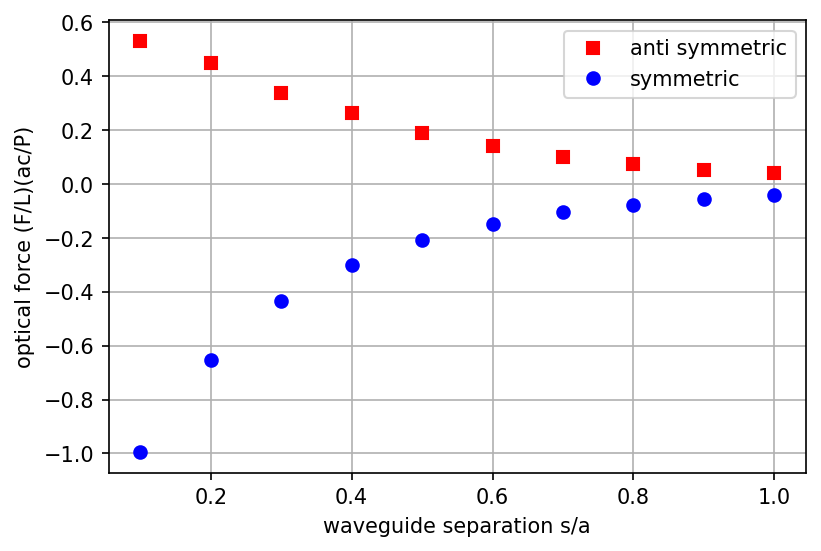

In [3]:
plt.figure(dpi=150)
plt.plot(s, -forces_odd / fluxes_odd, "rs", label="anti-symmetric")
plt.plot(s, -forces_even / fluxes_even, "bo", label="symmetric")
plt.grid(True)
plt.xlabel("waveguide separation s/a")
plt.ylabel("optical force (F/L)(ac/P)")
plt.legend(loc="upper right")
plt.show()

The following figure shows the $E_y$ mode profiles at a waveguide separation distance of 0.1 μm. This figure was generated using the [`plot2D`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#data-visualization) routine and shows the source and flux monitor (red hatches), force monitors (blue lines), and PMLs (green hatches) surrounding the cell. From the force spectra shown above, at this separation distance the anti-symmetric mode is repulsive whereas the symmetric mode is attractive.

![](https://meep.readthedocs.io/en/latest/images/parallel_wvgs_s0.1.png)

The MPB simulation is in [examples/parallel-wvgs-mpb.py](https://github.com/NanoComp/meep/blob/master/python/examples/parallel-wvgs-mpb.py). There are important differences related to the coordinate dimensions between the MPB and Meep scripts. In the MPB script, the 2d cell is defined using the $yz$ plane, the waveguide propagation axis is $x$,and the waveguide separation axis is $y$. As a consequence, the `num_bands` parameter is always `1` since the $y$ parity of the mode can be defined explicitly (i.e., `run_yodd_zodd` vs. `run_yeven_zodd`). This is different from the Meep script since Meep requires that a 2d cell be defined in the $xy$ plane. MPB has no such requirement.

In [4]:
import meep as mp
from meep import mpb
import numpy as np
import matplotlib.pyplot as plt

resolution = 128  # pixels/μm

Si = mp.Medium(index=3.45)

syz = 10
geometry_lattice = mp.Lattice(size=mp.Vector3(0, syz, syz))

k_points = [mp.Vector3(0.5)]

num_bands = 1
tolerance = 1e-9

a = 1.0  # waveguide width


def parallel_waveguide(s, yodd):
    geometry = [
        mp.Block(
            center=mp.Vector3(0, -0.5 * (s + a), 0),
            size=mp.Vector3(mp.inf, a, a),
            material=Si,
        ),
        mp.Block(
            center=mp.Vector3(0, 0.5 * (s + a), 0),
            size=mp.Vector3(mp.inf, a, a),
            material=Si,
        ),
    ]

    ms = mpb.ModeSolver(
        resolution=resolution,
        k_points=k_points,
        geometry_lattice=geometry_lattice,
        geometry=geometry,
        num_bands=num_bands,
        tolerance=tolerance,
    )

    if yodd:
        ms.run_yodd_zodd()
    else:
        ms.run_yeven_zodd()

    f = ms.get_freqs()[0]
    vg = ms.compute_group_velocity_component(mp.Vector3(1, 0, 0))[0]

    return f, vg


ss = np.arange(0.05, 1.15, 0.1)

f_odd = np.zeros(len(ss))
vg_odd = np.zeros(len(ss))
f_even = np.zeros(len(ss))
vg_even = np.zeros(len(ss))

for j in range(len(ss)):
    f_odd[j], vg_odd[j] = parallel_waveguide(ss[j], True)
    f_even[j], vg_even[j] = parallel_waveguide(ss[j], False)

ds = ss[1] - ss[0]


def compute_force(f, vg):
    f_avg = 0.5 * (f[:-1] + f[1:])
    df = f[1:] - f[:-1]
    vg_avg = 0.5 * (vg[:-1] + vg[1:])
    return -1 / f_avg * df / ds * 1 / vg_avg


force_odd = compute_force(f_odd, vg_odd)
force_even = compute_force(f_even, vg_even)

Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.55,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.55,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyodd.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 2.3206050395965576
solve_kpoint (0.5,0,0):
zoddyoddfreqs:, k index, k1, k2, k3, kmag/2pi, zoddyodd band 1
Solving for bands 1 to 1.

Finished solving for bands 1 to 1 after 19 iterations.
zoddyoddfreqs:, 1, 0.5, 0, 0, 0.5, 0.229408
elapsed time for k point: 38.052414655685425
total elapsed time for run: 40.36163353919983
done
Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.7,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.7,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyeven.
Initializing fields to random numbers...
1 k-po

zoddyevenfreqs:, k index, k1, k2, k3, kmag/2pi, zoddyeven band 1
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 17 iterations.
zoddyevenfreqs:, 1, 0.5, 0, 0, 0.5, 0.224479
elapsed time for k point: 34.263073205947876
total elapsed time for run: 36.65884232521057
done
Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.9,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.9,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating field

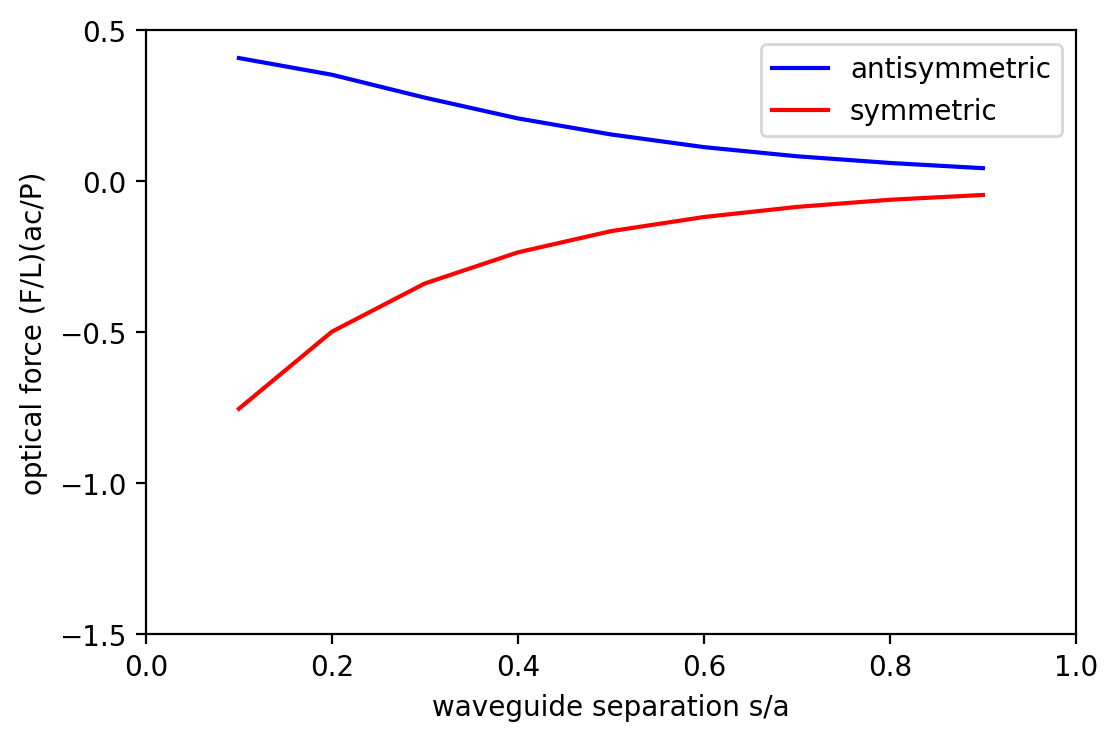

In [5]:
plt.figure(dpi=200)
plt.plot(ss[:-1], force_odd, "b-", label="anti-symmetric")
plt.plot(ss[:-1], force_even, "r-", label="symmetric")
plt.xlabel("waveguide separation s/a")
plt.ylabel("optical force (F/L)(ac/P)")
plt.legend(loc="upper right")
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(-1.5, 1.0, 0.5))
plt.show()